# Iterating on Naive Bayes performance with Yelp and IMDB

In [410]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

# Create function to identify all caps reviews & remove punctuation and make lowercase
def freshframe(frame, name): 
    name = pd.read_csv(frame, delimiter='\t', header=None)
    name.columns = ['Review', 'Outcome']
    name['allcaps'] = name['Review'].str.isupper()
    name['Review'] = name['Review'].str.replace(r'[^a-zA-Z\d\s:]', '')
    name['Review'] = name['Review'].str.lower()
    name['Review'] = name['Review'].str.strip()
    name['Review_length'] = name['Review'].str.len()
    min_max = preprocessing.MinMaxScaler()
    name['Review_length_scaled'] = min_max.fit_transform(name['Review_length'].values.reshape(-1, 1))
    name.drop(columns='Review_length', inplace=True)
    return name

dropme = ['Review', 'Outcome']

In [411]:
yelp1 = freshframe('../../_Datasets/yelp_labelled.txt', yelp)
imdb1 = freshframe('../../_Datasets/imdb_labelled.txt', imdb)

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [412]:
yelp1.head()

,Review,Outcome,allcaps,Review_length_scaled
0,wow loved this place,1,False,0.079710
1,crust is not good,0,False,0.057971
2,not tasty and the texture was just nasty,0,False,0.224638
3,stopped by during the late may bank holiday of...,1,False,0.557971
4,the selection on the menu was great and so wer...,1,False,0.355072


In [413]:
imdb1.head()

,Review,Outcome,allcaps,Review_length_scaled
0,a very very very slowmoving aimless movie abou...,0,False,0.009773
1,not sure who was more lost the flat character...,0,False,0.011728
2,attempting artiness with black white and clev...,0,False,0.022935
3,very little music or anything to speak of,0,False,0.004821
4,the best scene in the movie was when gerardo i...,1,False,0.013161


# Original model: BNB with selected negative words

In [414]:
neg_words = np.unique(yelp1.Review[yelp1.Outcome == 0].str.cat(sep=' ').split())
pos_words = np.unique(yelp1.Review[yelp1.Outcome == 1].str.cat(sep=' ').split())

diff_neg = np.setdiff1d(ar1=pd.Series(neg_words).value_counts().keys().ravel(), 
                    ar2=pd.Series(pos_words).value_counts().keys().ravel())
diff_pos = np.setdiff1d(ar1=pd.Series(pos_words).value_counts().keys().ravel(), 
                    ar2=pd.Series(neg_words).value_counts().keys().ravel())
# Examples of the entire word banks
print(diff_neg[40:50], '\n\n', diff_pos[40:50])

['appetizer' 'apple' 'arent' 'arepas' 'arrives' 'arriving' 'article'
 'asked' 'asking' 'atrocious'] 

 ['bbq' 'bean' 'beateous' 'beautiful' 'beautifully' 'beauty' 'beers'
 'bellies' 'belly' 'biscuit']


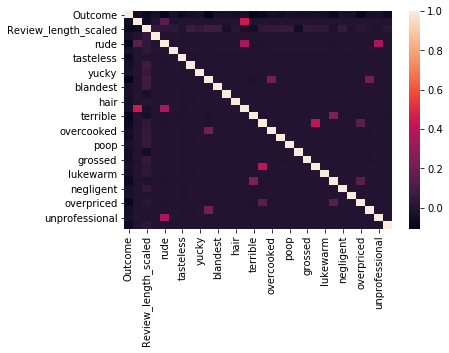

In [415]:
neg_word_list = ['insults', 'rude', 'stupid', 'tasteless', 'underwhelming', 'yucky', 'bland', 'blandest',
         'boring', 'hair', 'inconsiderate', 'terrible', 'horrible', 'overcooked', 'ok', 'poop', 
         'gross', 'grossed', 'humiliated', 'lukewarm', 'mediocre', 'negligent', 'missing', 'overpriced',
         'tasteless', 'undercooked', 'underwhelming', 'unprofessional', 'zero']

for word in neg_word_list:
    yelp1[word] = yelp1.Review.str.contains(r'\b' + word + r'\b', regex=True)
    
sns.heatmap(yelp1.corr())

In [416]:
BNB = BernoulliNB()
BNB.fit(yelp1.drop(columns=dropme), yelp1.Outcome)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

True     418
False    330
Name: Outcome, dtype: int64


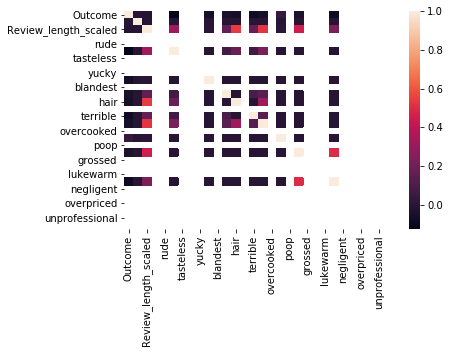

In [417]:
for word in neg_word_list:
    imdb1[word] = imdb1.Review.str.contains(r'\b' + word, regex=True)

first_pred = BNB.predict(imdb1.drop(columns=dropme))

print(pd.Series(imdb1.Outcome == first_pred).value_counts())
sns.heatmap(imdb1.corr())

# Ideas for further models

1. Words also from the positive outcome list
2. Verify this performance with cross validation
3. Use different feature selection to find most impactful words
4. Try another NB model
5. Use a much higher feature count

## 1. Combined negative and positive word lists

In [418]:
# An example of the positive word list
diff_pos[:15]

array(['2007', '23', '6', '7', '70', 'absolute', 'absolutley', 'accident',
       'accommodations', 'accomodate', 'accordingly', 'across', 'added',
       'affordable', 'afternoon'], dtype=object)

In [419]:
pos_word_list = ['beautifully', 'beauty', 'compliments', 'delicious', 'enjoyable', 'enthusiastic', 'experienced', 
                 'efficient', 'flavorful', 'flavourful', 'favorite', 'exceptional', 'generous', 'hella', 'magic', 
                 'loved', 'lovely', 'outstanding', 'reasonably', 'reasonable', 'satisfying', 'satisfied', 'solid', 
                 'unbelievable', 'unbelievably', 'wow', 'welcome', 'unique', 'unreal']

# Ensure the two lists are of equal length and treated somewhat fairly this way.
len(pos_word_list) == len(neg_word_list)

True

In [420]:
yelp = freshframe('../../_Datasets/yelp_labelled.txt', yelp)
imdb = freshframe('../../_Datasets/imdb_labelled.txt', imdb)

all_word_list = pos_word_list + neg_word_list
for word in all_word_list:
    imdb[word] = imdb.Review.str.contains(r'\b' + word + r'\b', regex=True)
    yelp[word] = yelp.Review.str.contains(r'\b' + word + r'\b', regex=True)

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [421]:
BNB = BernoulliNB()
BNB.fit(yelp.drop(columns=dropme), yelp.Outcome)
second_pred = BNB.predict(imdb.drop(columns=dropme))
print(pd.Series(second_pred == imdb.Outcome).value_counts(), '\n')
print('Checking to see which values are the same in first and second prediction: {}\n'
      .format(pd.Series(first_pred == second_pred).value_counts()))

True     415
False    333
Name: Outcome, dtype: int64 

Checking to see which values are the same in first and second prediction: True     743
False      5
dtype: int64



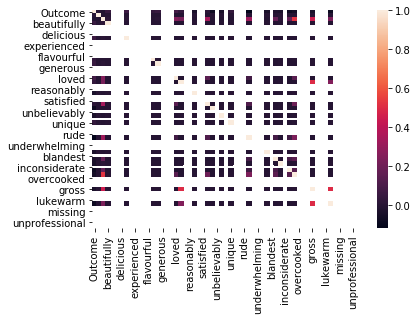

In [422]:
sns.heatmap(imdb.corr())

In [423]:
imdb.Outcome.value_counts()

1    386
0    362
Name: Outcome, dtype: int64

In [424]:
yelp.Outcome.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

## 2. Verify this performance with cross validation

In [425]:
cross_val_score(BNB, imdb.drop(columns=dropme), imdb.Outcome, cv=100)

array([0.5       , 0.5       , 0.625     , 0.5       , 0.5       ,
       0.625     , 0.625     , 0.625     , 0.5       , 0.5       ,
       0.625     , 0.5       , 0.625     , 0.625     , 0.5       ,
       0.5       , 0.5       , 0.625     , 0.625     , 0.5       ,
       0.625     , 0.5       , 0.5       , 0.75      , 0.5       ,
       0.5       , 0.5       , 0.625     , 0.5       , 0.5       ,
       0.625     , 0.5       , 0.625     , 0.5       , 0.5       ,
       0.625     , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.625     , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.625     , 0.375     , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.625     , 0.5       , 0.5       , 0.5       ,
       0.875     , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.625     , 0.75      , 0.57142857, 0.57142857, 0.57142857,
       0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.71428571,
       0.57142857, 0.57142857, 0.57142857, 1.        , 0.71428

#### Notes: second model

This combination of positive and negative word banks seems to perform slightly worse. We can see via a cross validation setup that the model is overfitting quite badly, with values ranging from 0.5 to 1.0.

## 3. Use different feature selection to find most impactful words

Below we can see the frequency of these words across the reviews. Many of them are quite low count, likely impacting the model's inability to make a good prediction.

In [426]:
for col in yelp.drop(columns=['Review', 'allcaps', 'Review_length_scaled', 'Outcome']).columns:
    print('Frequency of the word {}: {}'.format(str(col), yelp[col].value_counts()[1]))

Frequency of the word beautifully: 1
Frequency of the word beauty: 1
Frequency of the word compliments: 1
Frequency of the word delicious: 23
Frequency of the word enjoyable: 1
Frequency of the word enthusiastic: 1
Frequency of the word experienced: 1
Frequency of the word efficient: 1
Frequency of the word flavorful: 3
Frequency of the word flavourful: 1
Frequency of the word favorite: 3
Frequency of the word exceptional: 1
Frequency of the word generous: 3
Frequency of the word hella: 1
Frequency of the word magic: 1
Frequency of the word loved: 10
Frequency of the word lovely: 2
Frequency of the word outstanding: 3
Frequency of the word reasonably: 2
Frequency of the word reasonable: 5
Frequency of the word satisfying: 2
Frequency of the word satisfied: 1
Frequency of the word solid: 1
Frequency of the word unbelievable: 1
Frequency of the word unbelievably: 1
Frequency of the word wow: 3
Frequency of the word welcome: 1
Frequency of the word unique: 1
Frequency of the word unreal: 

In [427]:
# Fresh dataframes
yelp = freshframe('../../_Datasets/yelp_labelled.txt', yelp)
imdb = freshframe('../../_Datasets/imdb_labelled.txt', imdb)

for word in (list(diff_pos) + list(diff_neg)):
    yelp[word] = yelp.Review.str.contains((r'\b' + word + r'\b'), regex=True)  

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [428]:
new_word = (yelp.drop(columns=['Review', 'Outcome', 'Review_length_scaled']) * 1).sum().sort_values(ascending=False)
new_word_list = new_word.keys()[:50]
new_word_list

Index(['great', 'delicious', 'bad', 'minutes', 'wasnt', 'awesome', 'fantastic',
       'bland', 'terrible', 'excellent', 'slow', 'loved', 'perfect',
       'probably', 'rude', 'spot', 'took', 'happy', 'town', 'wonderful',
       'overpriced', 'waited', 'should', 'mediocre', 'her', 'horrible',
       'management', 'hard', 'either', 'money', 'poor', 'tender', 'sick',
       'tables', 'waste', 'tasteless', 'waiting', 'allcaps', '30', 'asked',
       'bacon', 'disappointing', 'bread', 'enjoyed', '10', 'barely', 'avoid',
       'wrong', 'anytime', 'reasonable'],
      dtype='object')

In [429]:
yelp = freshframe('../../_Datasets/yelp_labelled.txt', yelp)

for word in new_word_list:
    imdb[word] = imdb.Review.str.contains(r'\b' + word + r'\b', regex=True)
    yelp[word] = yelp.Review.str.contains(r'\b' + word + r'\b', regex=True)

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


True     459
False    289
Name: Outcome, dtype: int64 




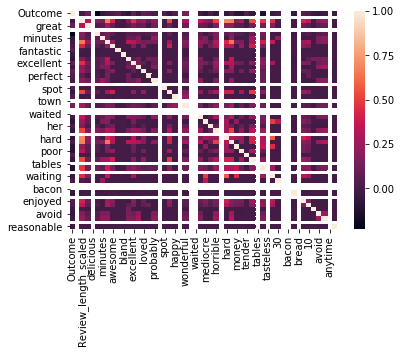

In [430]:
BNB = BernoulliNB()
BNB.fit(yelp.drop(columns=dropme), yelp.Outcome)
third_pred = BNB.predict(imdb.drop(columns=dropme))
print((third_pred == imdb.Outcome).value_counts(), '\n\n')
sns.heatmap(imdb.corr())

## 4. Try another NB model

In [431]:
GNB = GaussianNB()
GNB.fit(yelp1.drop(columns=dropme), yelp1.Outcome)
fourth_pred = GNB.predict(imdb1.drop(columns=dropme))
(fourth_pred == imdb1.Outcome).value_counts()

True     418
False    330
Name: Outcome, dtype: int64

#### Notes: GNB

There doesn't seem to be any difference here at all in predictive power.

## 5. Model with many more features

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


True     467
False    281
Name: Outcome, dtype: int64 



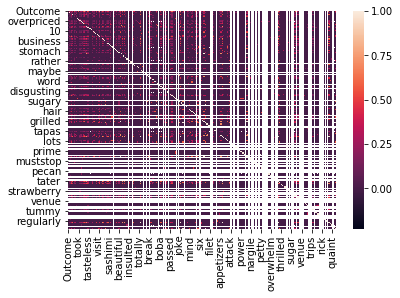

In [432]:
# Fresh dataframes
yelp = freshframe('../../_Datasets/yelp_labelled.txt', yelp)
imdb = freshframe('../../_Datasets/imdb_labelled.txt', imdb)

newer_word_list = new_word.keys()[:500]
for word in newer_word_list:
    imdb[word] = imdb.Review.str.contains(r'\b' + word + r'\b', regex=True)
    yelp[word] = yelp.Review.str.contains(r'\b' + word + r'\b', regex=True)
    
BNB = BernoulliNB()
BNB.fit(yelp.drop(columns=dropme), yelp.Outcome)
fifth_pred = BNB.predict(imdb.drop(columns=dropme))
print((imdb.Outcome == fifth_pred).value_counts(), '\n')
sns.heatmap(imdb.corr())

#### Notes: Much higher feature count

Although this looks to have the best performance, it still doesn't produce any impressive numbers, and I think it still has a considerably higher computational cost. 